# Topic analysis with party embeddings

In [1]:
import pandas as pd
from tqdm import tqdm
from gensim.models import Word2Vec
import nltk
import numpy as np
import gensim
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/furiosa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Preprocess text

notes:
Remove parties βουλη, αντιπολιτευση, 'ανεξαρτητοι (εκτος κομματος)', # 'εξωκοινοβουλευτικός':[],
replace multiple spaces with one
is anel the same with summaxia?
γενικη κλιση στα ονοματα
πως θα ξεχωρίσω το συνασπισμο απο τον συριζα
ου να προηγείται του ος σε ονόματα μιας λεξης για να βρισκει σωστα το συνασπισμου

In [2]:
party_alts = {
'@μερα25':['Μ(έ|ε)ΡΑ25', 
           '((Μ(έ|ε)τωπο)|(Μετ(ώ|ω)που)) Ευρωπα(ϊ|ι)κ(ή|η)ς Ρεαλιστικ(ή|η)ς Ανυπακο(ή|η)ς', 
           'ΜΕΡΑ25'],
    
'@νδ':['Ν(έ|ε)α(ς*) Δημοκρατ(ί|ι)α(ς*)'], #' Ν.Δ.(?!\w)',
       #' ΝΔ(?!\w)'],  #look-ahead assertion: not followed by a word character: letter, number, underscore
    # ν.δ. νομοθετικό διάταγμα το γράφουν και με κεφαλαία
'η @νδ':['(Η|η) ΝΔ(?!\w)', '(Η|η) Ν.Δ.(?!\w)'], 
'της @νδ':['(Τ|τ)ης ΝΔ(?!\w)', '(Τ|τ)ης Ν.Δ.(?!\w)'],
'τη @νδ':['(Τ|τ)η ΝΔ(?!\w)', '(Τ|τ)η Ν.Δ.(?!\w)'],
    
#add space in front of small ids that could be wrongly identified in the middle of other words in caps lock
# space is not added also at the end of the string but look-ahead assertion that no word character follows.
    
' @δησυ':['Δημοκρατικ(ή|η)(ς*) Συμπαρ(ά|α)ταξη(ς*)', 
         ' ΔΗ\.ΣΥ\.(?!\w)', 
         ' ΔΗΣΥ(?!\w)'],
    
' @συριζα':['((Συνασπισμ(ό|ο)ς)|(Συνασπισμο(ύ|υ))) Ριζοσπαστικ(ή|η)ς Αριστερ(ά|α)ς', ' ΣΥΡΙΖΑ(?!\w)',' ΣΥ\.ΡΙΖ\.Α(?!\w)'],
# 'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια':[],
    
'@ελληνικη_λυση':['Ελληνικ(ή|η)(ς*) Λ(ύ|υ)ση(ς*)((\s*)(\-*)(\s*)Κυρι(ά|α)κος Βελ(ό|ο)πουλος)?'],
                  #'Ελληνικ(ή|η)(ς*) Λ(ύ|υ)ση(ς*)'],
    # maybe just make 
' @πολαν':['Πολιτικ(ή|η)(ς*) (Ά|Α)νοιξη(ς*)', ' ΠΟΛ\.ΑΝ\.(?!\w)', ' ΠΟΛΑΝ(?!\w)'],
    
'@ανεξαρτητοι_δημοκρατικοι_βουλευτες':['Ανεξ(ά|α)ρτητοι Δημοκρατικο(ί|ι) Βουλευτ(έ|ε)ς', 
                                       'Ανεξ(ά|α)ρτητων Δημοκρατικ(ώ|ω)ν Βουλευτ(ώ|ω)ν', 
                                       'Ανεξ(ά|α)ρτητους Δημοκρατικο(ύ|υ)ς Βουλευτ(έ|ε)ς'],
    
' @ανελ':['Ανεξ(ά|α)ρτητοι (Έ|Ε)λληνες((\s*)(\-*)(\s*)Π(ά|α)νος Καμμ(έ|ε)νος)?', 
         'Ανεξ(ά|α)ρτητων Ελλ(ή|η)νων((\s*)(\-*)(\s*)Π(ά|α)νος Καμμ(έ|ε)νος)?', 
         'Ανεξ(ά|α)ρτητους (Έ|Ε)λληνες((\s*)(\-*)(\s*)Π(ά|α)νος Καμμ(έ|ε)νος)?', 
         ' ΑΝ.ΕΛ.(?!\w)', ' ΑΝΕΛ(?!\w)', 
         'Ανεξ(ά|α)ρτητοι (Έ|Ε)λληνες(\s*)(\-*)(\s*)Εθνικ(ή|η) Πατριωτικ(ή|η) Δημοκρατικ(ή|η) Συμμαχ(ί|ι)α'],
    
' @δηανα':['Δημοκρατικ(ή|η)(ς*) Αναν(έ|ε)ωση(ς*)', ' ΔΗΑΝΑ(?!\w)', ' ΔΗ\.ΑΝΑ\.(?!\w)'],
    
' @κιναλ':['Κ(ί|ι)νημα Αλλαγ(ή|η)ς', ' ΚΙΝΑΛ(?!\w)', ' ΚΙΝ\.ΑΛ\.(?!\w)', 'Κιν(ή|η)ματος Αλλαγ(ή|η)ς'],
    
' @δηκκι':['Δημοκρατικ(ό|ο) Κοινωνικ(ό|ο) Κ(ί|ι)νημα','Δημοκρατικο(ύ|υ) Κοινωνικο(ύ|υ) Κιν(ή|η)ματος', 
          ' ΔΗ\.Κ\.ΚΙ\.(?!\w)', ' ΔΗΚΚΙ(?!\w)'],
    
'@συνασπισμος':['Συνασπισμ(ό|ο|ός|ος|ού|ου) (τ|Τ)ης Αριστερ(ά|α)ς (τ|Τ)ων Κινημ(ά|α)των (κ|Κ)αι (τ|Τ)ης Οικολογ(ί|ι)ας', 
                'Συνασπισμ(ού|ου)(?!\s+Ριζοσπαστικ)',
                'Συνασπισμ(ός|ος|ό|ο)(?!\s+Ριζοσπαστικ)', 
                ' ΣΥΝ(?!\w)'], #with \s+ γιατί το ΣΥΝ ειναι συνηθες συνθετικο λεξεων?
    
' @πασοκ':['Πανελλ(ή|η)νιο Σοσιαλιστικ(ό|ο) Κ(ί|ι)νημα', 
          'Πανελλ(ή|η)νιου Σοσιαλιστικο(ύ|υ) Κιν(ή|η)ματος',
          ' ΠΑΣΟΚ(?!\w)', ' ΠΑ\.ΣΟ\.Κ\.(?!\w)'],
    
' @κκε':['Κομμουνιστικ(ό|ο) Κ(ό|ο)μμα Ελλ(ά|α)δ(ο|α)ς', 
        'Κομμουνιστικο(ύ|υ) Κ(ό|ο)μματος Ελλ(ά|α)δ(ο|α)ς',
        ' Κ\.Κ\.Ε\.(?!\w)', ' ΚΚΕ(?!\w)'],
    
' @λαος':['Λα(ϊ|ι)κ(ό|ο)(ς*) Ορθ(ό|ο)δοξο(ς*) Συναγερμ(ό|ο)(ς*)', 
         'Λα(ϊ|ι)κο(ύ|υ) Ορθ(ό|ο)δοξου Συναγερμο(ύ|υ)', 
         ' ΛΑ\.Ο\.Σ\.(?!\w)',' ΛΑΟΣ(?!\w)'], #not λαος because it is used for referring to people
    
' @χα':['Λα(ϊ|ι)κ(ό|ο)(ς*) Σ(ύ|υ)νδεσμο(ς*)(\s*)(\-*)(\s*)Χρυσ(ή|η) Αυγ(ή|η)', 
       'Λα(ϊ|ι)κο(ύ|υ) Συνδ(έ|ε)σμου(ς*)(\s*)(\-*)(\s*)Χρυσ(ή|η) Αυγ(ή|η)',
       'Χρυσ(ή|η)(ς*) Αυγ(ή|η)(ς*)', 
       ' Χ\.Α\.(?!\w)',],
    
' @οε':['Οικολ(ό|ο)γοι(\s*)(\-*)(\s*)Εναλλακτικο(ί|ι)', 
       'Οικολ(ό|ο)γων(\s*)(\-*)(\s*)Εναλλακτικ(ώ|ω)ν',
#        ' Ο\.Ε\.(?!\w)' ομορρυθμη εταιρεια συνηθως
       ],
    
' @λαε':['Λα(ϊ|ι)κ(ή|η)(ς*) Εν(ό|ο)τητα(ς*)', ' ΛΑ\.Ε\.(?!\w)', ' ΛΑΕ(?!\w)'],
    
'@ποταμι':['Ποτ(ά|α)μι'],
    
' @εκ':['(Έ|Ε)νωση(ς*) Κεντρ(ώ|ω)ων', 
#         ' Ε\.Κ\.(?!\w)' #αναφορα το 1989 σε κάτι άλλο με τα ίδια αρχικά
       ],
    
'@δημαρ':['Δημοκρατικ(ή|η)(ς*) Αριστερ(ά|α)(ς*)', ' ΔΗΜΑΡ(?!\w)', ' ΔΗΜ\.ΑΡ\.(?!\w)'],

}

def replace_political_parties_with_ids(text):
    
    text = re.sub('\s\s+' , ' ', text)

    for key_name, alt_names in party_alts.items():
        text = re.sub('|'.join(alt_names), key_name, text)
        
    text = re.sub('\s\s+' , ' ', text)
    
    return(text)

example = 'Της Δημοκρατικη Ανανέωση; Του Συνασπισμού και του ΠΑΣΟΚ.'
replace_political_parties_with_ids(example)
# df[df['speech'].str.contains("@")].speech.to_list()[:100]

'Της @δηανα; Του @συνασπισμος και του @πασοκ.'

Replace alternative party names with specific party ids

In [3]:
# df = pd.read_csv('../out_files/tell_all_corrected.csv')
# df['speech'] = df['speech'].apply(replace_political_parties_with_ids)
# df.to_csv('../out_files/tell_all_replaced_parties_with_@ids.csv', encoding='utf-8', index=False, na_rep=np.nan)

Preprocess text for word2vec model input in parameter sentences. Convert text to list of sentences and each sentence to a list of words. Set new rule to tokenizer to avoid splitting new party ids. 

In [4]:
from nltk.tokenize import MWETokenizer
from nltk import word_tokenize

tokenizer = MWETokenizer([
    ('@', 'μερα25'), ('@', 'νδ'), ('@', 'δησυ'), ('@', 'συριζα'),
    ('@', 'ελληνικη_λυση'), ('@', 'πολαν'), 
    ('@', 'ανεξαρτητοι_δημοκρατικοι_βουλευτες'), 
    ('@', 'ανελ'), ('@', 'δηανα'), ('@', 'κιναλ'), ('@', 'δηκκι'),
    ('@', 'συνασπισμος'), ('@', 'πασοκ'), ('@', 'κκε'),
    ('@', 'λαος'), ('@', 'χα'), ('@', 'οε'), ('@', 'λαε'), 
    ('@', 'ποταμι'),('@', 'εκ'), ('@', 'δημαρ'),
    ])

example = 'Οι @ανεξαρτητοι_δημοκρατικοι_βουλευτες ?'
tokenizer.tokenize(word_tokenize(example))

['Οι', '@_ανεξαρτητοι_δημοκρατικοι_βουλευτες', '?']

Read again csv with replaced ids

In [34]:
print('Reading file...')
df = pd.read_csv('../out_files/tell_all_replaced_parties_with_@ids.csv')

Reading file...


In [36]:
df.head()

member_name sitting_date parliamentary_period  \
0  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   
1  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   
2  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   
3                           NaN   03/07/1989             period 5   
4  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   

  parliamentary_session parliamentary_sitting                 political_party  \
0             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
1             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
2             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
3             session 1             sitting 1                           βουλη   
4             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   

                                     government member_region  \
0  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
1  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
2  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
3  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']           NaN   
4  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   

                                              roles member_gender  \
0  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
1  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
2  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
3                                               NaN           NaN   
4  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   

   speaker_info                                             speech  
0    προεδρευων   Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...  
1    προεδρευων   Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...  
2    προεδρευων   Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ...  
3  βουλευτης/ες                                  Μάλιστα, μάλιστα.  
4    προεδρευων   Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...

Count the occurrences of the ids in the corpus. Compare occurrences.

In [37]:
party_ids = []

id_occur={}
for key in party_alts.keys():
    key = key.strip()
    id_occur[key] = df.speech.str.count(key).sum()
    
    new_key = key.split('@')[0]+'@'+'_'+key.split('@')[1] #add _ because tokenizer transforms them later on
    party_ids.append(new_key)
    
party_ids.remove('η @_νδ')
party_ids.remove('της @_νδ')
party_ids.remove('τη @_νδ')

print(id_occur)

{'@μερα25': 1374, '@νδ': 174288, 'η @νδ': 61629, 'της @νδ': 96916, 'τη @νδ': 22314, '@δησυ': 4609, '@συριζα': 60085, '@ελληνικη_λυση': 1395, '@πολαν': 1469, '@ανεξαρτητοι_δημοκρατικοι_βουλευτες': 333, '@ανελ': 7700, '@δηανα': 72, '@κιναλ': 3193, '@δηκκι': 3384, '@συνασπισμος': 15350, '@πασοκ': 148624, '@κκε': 34760, '@λαος': 11229, '@χα': 13415, '@οε': 67, '@λαε': 34, '@ποταμι': 3557, '@εκ': 2755, '@δημαρ': 6535}


In [38]:
print(party_ids)

['@_μερα25', '@_νδ', '@_δησυ', '@_συριζα', '@_ελληνικη_λυση', '@_πολαν', '@_ανεξαρτητοι_δημοκρατικοι_βουλευτες', '@_ανελ', '@_δηανα', '@_κιναλ', '@_δηκκι', '@_συνασπισμος', '@_πασοκ', '@_κκε', '@_λαος', '@_χα', '@_οε', '@_λαε', '@_ποταμι', '@_εκ', '@_δημαρ']


Group by period.

In [39]:
import datetime

print('Selecting subset of dates...')
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
# df = df.loc[(df.sitting_date>='2018-01-01')]

print('Grouping by period...')
df = df.groupby(['parliamentary_period'])['speech'].apply(' '.join).reset_index()

print('Tokenizing per period...')
print(datetime.datetime.now().time())
df.speech = df.speech.apply(
    lambda x: [tokenizer.tokenize(word_tokenize(sentence.lower())) for sentence in nltk.sent_tokenize(x)]) #list of lists

print(datetime.datetime.now().time())
# Adjust period 18 name in order to easily sort periods later on
df.parliamentary_period.loc[(df.parliamentary_period=='period 18 review 9')] = 'period 18'
grouped_by_period = df.copy()
grouped_by_period.columns = ['period', 'speech']


Selecting subset of dates...
Grouping by period...
Tokenizing per period...
19:37:43.636775
20:55:45.854348


In [65]:
# grouped_by_period.to_csv('../out_files/tell_all_PERperiod_tokenized.csv', encoding='utf-8', index=False, na_rep=np.nan)

In [66]:
print(grouped_by_period.head())

      period                                             speech
0  period 10  [[τέλος, ,, επιστολή, της, βουλευτού, α, ', πε...
1  period 11  [[κυρίες, και, κύριοι, βουλευτές, ,, κηρύσσετα...
2  period 12  [[κυρίες, και, κύριοι, βουλευτές, ,, κηρύσσετα...
3  period 13  [[κυρίες, και, κύριοι, βουλευτές, ,, κηρύσσετα...
4  period 14  [[κυρίες, και, κύριοι, βουλευτές, ,, συγκαλείτ...


Procrustes

In [41]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    base_embed.init_sims()
    other_embed.init_sims()

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    # base_vecs = in_base_embed.syn0norm
    base_vecs = in_base_embed.wv.vectors_norm
    # other_vecs = in_other_embed.syn0norm
    other_vecs = in_other_embed.wv.vectors_norm
    
    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm) by "ortho"
    # other_embed.syn0norm = other_embed.syn0 = (other_embed.syn0norm).dot(ortho)
    other_embed.wv.vectors_norm = other_embed.wv.vectors = (other_embed.wv.vectors_norm).dot(ortho)
    return other_embed

def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1, m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count, reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = m.wv.vectors_norm
        new_arr = np.array([old_arr[index] for index in indices])
        # m.syn0norm = m.syn0 = new_arr
        m.wv.vectors_norm = m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.wv.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index, word in enumerate(common_vocab):
            old_vocab_obj = old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1, m2)

Train one word2vec model for each period. Save at directory wordmodels 2b

In [42]:
import os

models_dir =  '../out_files/wordmodels/with_ids/PERperiod/'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

for period, texts in tqdm(zip(grouped_by_period.period, grouped_by_period.speech)):
    model = Word2Vec(sentences=texts, size=100, window=5, min_count=1, workers=4)
    model.save('../out_files/wordmodels/with_ids/PERperiod/'+period+'.mdl')

14it [42:36, 182.61s/it]


For each period, align each model with the previous one.

Get list of periods sorted chronologically.

In [43]:
# Sort periods based on number in the string

import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

periods = (grouped_by_period.period.to_list())
periods.sort(key=natural_keys)
print(periods)


['period 5', 'period 6', 'period 7', 'period 8', 'period 9', 'period 10', 'period 11', 'period 12', 'period 13', 'period 14', 'period 15', 'period 16', 'period 17', 'period 18']


Align models per period

In [44]:
import glob
import shutil
import tqdm.notebook as tq

align_dest_dir = models_dir+'alinged/'

if not os.path.exists(align_dest_dir):
    os.makedirs(align_dest_dir)

for file in glob.glob(models_dir+periods[0]+'.mdl*'):
    shutil.copy(file, align_dest_dir)

#--------

m_t0 = Word2Vec.load(models_dir+periods[0]+'.mdl')

for period in tq.tqdm(periods[1:]):  
  m_t1 = Word2Vec.load(models_dir+period+'.mdl')
  m_t1_aligned = smart_procrustes_align_gensim(m_t0, m_t1)
  m_t1_aligned.save(align_dest_dir+period+'.mdl')
  m_t0 = m_t1_aligned

In [45]:
# models[periods[0]].wv.vocab.keys()

### Overlap of nearest neighbors for party vectors

Compute 10 nn for each candidate party name, per period.

In [46]:
top_nn_per_period = []

models = {p:Word2Vec.load(align_dest_dir+p+'.mdl') for p in periods}

print(periods)
for period in periods:
    
    model = models[period]

    for key in party_alts.keys():
        
        tokenized_key = (key.split('@')[0]+'@'+'_'+key.split('@')[1]).strip()
#         print(tokenized_key)

        if tokenized_key in model.wv.vocab.keys():

            party_vector = model.wv[tokenized_key]
            most_similar_words = [word for word, similarity in model.wv.most_similar(positive=[tokenized_key], topn=15)]

        else:
            print(tokenized_key, " not in vocab of period "+period)
            party_vector = np.nan
            most_similar_words = np.nan
            

    #         print(nn_30words)

        top_nn_per_period.append([period, tokenized_key, party_vector, most_similar_words])

len(top_nn_per_period)


['period 5', 'period 6', 'period 7', 'period 8', 'period 9', 'period 10', 'period 11', 'period 12', 'period 13', 'period 14', 'period 15', 'period 16', 'period 17', 'period 18']
@_μερα25  not in vocab of period period 5
η @_νδ  not in vocab of period period 5
της @_νδ  not in vocab of period period 5
τη @_νδ  not in vocab of period period 5
@_δησυ  not in vocab of period period 5
@_συριζα  not in vocab of period period 5
@_ελληνικη_λυση  not in vocab of period period 5
@_πολαν  not in vocab of period period 5
@_ανεξαρτητοι_δημοκρατικοι_βουλευτες  not in vocab of period period 5
@_ανελ  not in vocab of period period 5
@_κιναλ  not in vocab of period period 5
@_δηκκι  not in vocab of period period 5
@_λαος  not in vocab of period period 5
@_χα  not in vocab of period period 5
@_οε  not in vocab of period period 5
@_λαε  not in vocab of period period 5
@_ποταμι  not in vocab of period period 5
@_εκ  not in vocab of period period 5
@_δημαρ  not in vocab of period period 5
@_μερα25  not in 

336

In [47]:
nn_per_period_df = pd.DataFrame(data=top_nn_per_period,
                     columns=['period', 'party_id', 'party_vector', 'top_nn']
                    )
nn_per_period_df.head(5)

period  party_id                                       party_vector  \
0  period 5  @_μερα25                                                NaN   
1  period 5      @_νδ  [2.923077, -1.9994245, -1.2064791, 1.659255, -...   
2  period 5    η @_νδ                                                NaN   
3  period 5  της @_νδ                                                NaN   
4  period 5   τη @_νδ                                                NaN   

                                              top_nn  
0                                                NaN  
1  [@_πασοκ, τότε, @_συνασπισμος, αριστεράς, κυβέ...  
2                                                NaN  
3                                                NaN  
4                                                NaN

In [48]:
# nn_per_period_df.dropna(thresh=1)
nn_per_period_df = nn_per_period_df[nn_per_period_df.party_vector.notnull()]

In [61]:
nn_per_period_df.head()

(52, 5)

Lemmatize nn words

In [50]:
import spacy
import el_core_news_lg
#python -m spacy download el_core_news_lg
nlp = el_core_news_lg.load()

In [51]:
import string

def spacy_lemmatizing(list_of_words):
    lemmas = []
    for word in list_of_words:
        doc = nlp(word)
        lemmas.append(' '.join([token.lemma_ for token in doc])) # maybe it should be lemma_ instead of lemma
    return lemmas

# remove punctuation
def preprocess_nearest_neighbors(n_list):

    other_parties_as_neighbors = [n for n in n_list if n.startswith('@')]
    neighbors_list = [n for n in n_list if n not in other_parties_as_neighbors]

    removed_punct_neighbors =  [w.translate(str.maketrans('', '', string.punctuation)) 
                                for w in neighbors_list if w!='']
    lemmas = []
    for word in removed_punct_neighbors:
        doc = nlp(word)
        lemmas.append(' '.join([token.lemma_ for token in doc]))
       
    lemmas+=other_parties_as_neighbors
    
    return list(set(lemmas))



nn_per_period_df['top_nn_lemmas'] = nn_per_period_df['top_nn']#.apply(
#     lambda x: preprocess_nearest_neighbors(x))

nn_per_period_df.head(6)
print(nn_per_period_df.iloc[0][3])
print(nn_per_period_df.iloc[0][4])


['@_πασοκ', 'τότε', '@_συνασπισμος', 'αριστεράς', 'κυβέρνησης', 'απορρίπτατε', 'κυβέρνηση', 'σύντροφοι', 'προόδου', 'αναγγέλθηκε', 'αντιπολίτευσης', 'τζαννή', 'αξιωματικής', 'πλευρά', 'βάρκιζα']
['@_πασοκ', 'τότε', '@_συνασπισμος', 'αριστεράς', 'κυβέρνησης', 'απορρίπτατε', 'κυβέρνηση', 'σύντροφοι', 'προόδου', 'αναγγέλθηκε', 'αντιπολίτευσης', 'τζαννή', 'αξιωματικής', 'πλευρά', 'βάρκιζα']


Compute jaccard similarity for all parties and for all periods

In [52]:
import string
import itertools


def jaccard_metrics(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    words_inter = s1.intersection(s2)
    words_union = s1.union(s2)
    intersection_No = len(s1.intersection(s2))
    union_No = len(s1.union(s2))
    jaccard = float(intersection_No/union_No)
    return jaccard, intersection_No, union_No, words_inter, words_union


def step_one_pairs(list_of_items):
    return [(periods[i],periods[i+1]) for i in range(len(list_of_items)-1)]


period_pairs = step_one_pairs(periods)
print(period_pairs)

sim_list = []

available_parties = list(set(nn_per_period_df.party_id.to_list()))

for party_id in available_parties:
    print(party_id)
    for pair in period_pairs:

        if (party_id in nn_per_period_df.loc[(nn_per_period_df.period==pair[0])].
            party_id.to_list()) and (party_id in nn_per_period_df.loc[(nn_per_period_df.period==pair[1])]
                                     .party_id.to_list()):

            list1 = nn_per_period_df.loc[(nn_per_period_df.period==pair[0])
                                                &(nn_per_period_df.party_id==party_id)
                                                ].top_nn_lemmas.iloc[0]

            list2 = nn_per_period_df[(nn_per_period_df.period==pair[1])
                                                &(nn_per_period_df.party_id==party_id)
                                                ].top_nn_lemmas.iloc[0]

            jac_sim, intersection_No, union_No, words_inter, words_union = jaccard_metrics(list1, list2)

            sim_list.append([pair,party_id, jac_sim, intersection_No, union_No, words_inter, words_union])

jaccard_df = pd.DataFrame(data=sim_list, columns = ['period_pairs', 'party', 'jaccard_sim', 'intersection_No', 'union_No', 
                                                   'words_intersection','words_union'])

print(jaccard_df.head())



[('period 5', 'period 6'), ('period 6', 'period 7'), ('period 7', 'period 8'), ('period 8', 'period 9'), ('period 9', 'period 10'), ('period 10', 'period 11'), ('period 11', 'period 12'), ('period 12', 'period 13'), ('period 13', 'period 14'), ('period 14', 'period 15'), ('period 15', 'period 16'), ('period 16', 'period 17'), ('period 17', 'period 18')]
@_δηανα
@_συνασπισμος
@_πασοκ
@_κκε
@_νδ
            period_pairs          party  jaccard_sim  intersection_No  \
0   (period 5, period 6)  @_συνασπισμος     0.363636                8   
1   (period 6, period 7)  @_συνασπισμος     0.250000                6   
2   (period 7, period 8)  @_συνασπισμος     0.034483                1   
3   (period 8, period 9)  @_συνασπισμος     0.034483                1   
4  (period 9, period 10)  @_συνασπισμος     0.764706               13   

   union_No                                 words_intersection  \
0        22  {αριστεράς, τζαννή, @_πασοκ, τζαννετάκη, εισηγ...   
1        24  {αριστεράς, κοινοβο

In [54]:
print(jaccard_df.head(2))

(47, 7)


In [100]:
import datetime as dt
period_to_year = pd.read_csv("../out_files/tell_all_corrected.csv") # dd/mm/yy 03/07/1989
period_to_year.sitting_date = pd.to_datetime(period_to_year.sitting_date) # yy-mm-dd 1989-03-07
period_to_year['year'] = period_to_year['sitting_date'].dt.year.astype(str)
period_to_year = period_to_year.groupby(['parliamentary_period'])['year'].apply(','.join).reset_index()
period_to_year.year = period_to_year.year.apply(lambda x : list(set(x.split(','))))
period_to_year.year = period_to_year.year.apply(lambda x : sorted(x))
period_to_year.loc[(period_to_year.parliamentary_period=='period 18 review 9'), 'parliamentary_period'] = 'period 18'

In [102]:
def period_pair_to_year_range(period_pair,period_to_year_df):
#     print('here')
#     print(period_pair)
#     pair_start = 'period '+str(period_pair[0])
#     pair_end = 'period '+str(period_pair[1])
#     print('there')
    start_year = period_to_year_df.loc[(period_to_year_df.parliamentary_period==period_pair[0])].year.values[0][0]
#     print(start_year)
#     print('1')
    end_year = period_to_year_df.loc[(period_to_year_df.parliamentary_period==period_pair[1])].year.values[0][-1]
#     print(end_year)
    range = start_year+'-'+end_year
    return(range)

print(period_pair_to_year_range(('period 13', 'period 14'), period_to_year))
# print(period_pair_to_year_range((13, 14), period_to_year))

2009-2012


In [104]:
jaccard_df['years'] = jaccard_df.apply(lambda x: period_pair_to_year_range(x.period_pairs, period_to_year), axis=1)


Visualize

['1989-1990', '1989-1993', '1990-1994', '1993-2000', '1996-2004', '2000-2007', '2004-2009', '2007-2012']
['1989-1990', '1989-1993', '1990-1994', '1993-2000', '1996-2004', '2000-2007', '2004-2009', '2007-2012', '2009-2012', '2012-2014', '2012-2019', '2015-2019', '2015-2020']
['1989-1990', '1989-1993', '1990-1994', '1993-2000', '1996-2004', '2000-2007', '2004-2009', '2007-2012', '2009-2012', '2012-2014', '2012-2019', '2015-2019', '2015-2020']
['1989-1990', '1989-1993', '1990-1994', '1993-2000', '1996-2004', '2000-2007', '2004-2009', '2007-2012', '2009-2012', '2012-2014', '2012-2019', '2015-2019', '2015-2020']


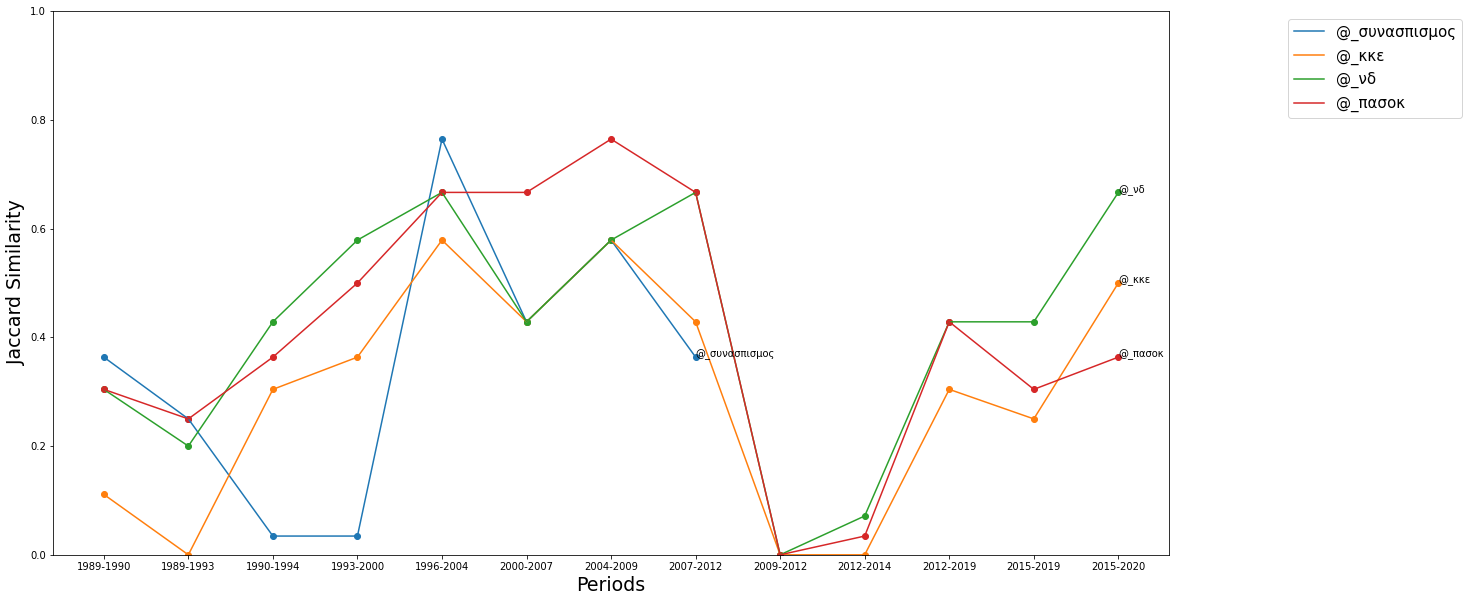

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
from decimal import Decimal
from collections import defaultdict 
import random



plt.figure(figsize=(20, 10)) 
colors = sns.color_palette('colorblind').as_hex()
# plt.xlim([5, 18])
plt.ylim([0, 1.])



for party in list(set(jaccard_df.party.to_list())):

    party_subdf = jaccard_df.loc[(jaccard_df.party==party)]
    
    if party_subdf.shape[0]>1:
        
        party_subdf = party_subdf.sort_values('years')
#         period_pair_to_year_range
        X = party_subdf.years.to_list()
        Y = party_subdf.jaccard_sim.to_list()

#         print(type(Y))
#         new_X = [(int(x[0].split()[1])+int(x[1].split()[1]))/2 for x in X]
        print((X))
        plt.scatter(X,Y)
#         short_pair = [short_party_name_dir[pair[0]], short_party_name_dir[pair[1]]]
#         add_x = (random.uniform(0,0.5))
#         add_y = (random.uniform(0,0.09))
        plt.plot(X,Y, label=party)

        plt.annotate(party,
#             , fontsize=12.5, 
             xy=(X[-1], Y[-1]), 
             xytext=(X[-1], Y[-1]),
#              arrowprops=dict(arrowstyle="->")
            ) #8

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.labelsize'] = 19

plt.xticks()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
#     print(handles)
#     print(labels)
plt.legend()
#     plt.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=15)
    
    
# plt.xlim([0, 1])
# plt.ylim([0, 0.5])
plt.ylabel('Jaccard Similarity')
plt.xlabel('Periods')
plt.show() 

### Cosine similarity of party vectors/embeddings through periods